In [3]:
import os
import gc
import math
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.impute import SimpleImputer
import joblib
from scipy import stats

In [4]:
hist_data = pd.read_csv('/content/historical_data.csv', nrows=1000)
print("Sample columns (historical):", hist_data.columns.tolist())
feargreed = pd.read_csv('/content/fear_greed_index.csv', nrows=1000)
print("Sample columns (fear_greed):", feargreed.columns.tolist())

Sample columns (historical): ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sample columns (fear_greed): ['timestamp', 'value', 'classification', 'date']


In [5]:
# Identifying object columns in sample that are likely categorical
likely_cats = []
for c in hist_data.select_dtypes(include=["object"]).columns:
    if c.lower() in ("account", "coin", "side", "direction", "transaction hash", "transaction_hash", "txhash", "t_hash"):
        likely_cats.append(c)

# Map to dtype dict
dtype_map = {c: "category" for c in likely_cats}


for c in hist_data.select_dtypes(include=["int64", "float64"]).columns:
    pass

print("dtype_map hint:", dtype_map)


dtype_map hint: {'Account': 'category', 'Coin': 'category', 'Side': 'category', 'Direction': 'category', 'Transaction Hash': 'category'}


In [6]:
historical = pd.read_csv('/content/historical_data.csv',dtype=dtype_map,parse_dates=["Timestamp IST"] if "Timestamp IST" in hist_data.columns else None,low_memory=False)

fear_greed = pd.read_csv('/content/fear_greed_index.csv', low_memory=False)

# Standardizing column names to snake_case
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
        .str.replace(" ", "_")
        .str.replace("/", "_")
        .str.replace("-", "_")
        .str.lower()
    )
    return df

historical = clean_cols(historical)
fear_greed = clean_cols(fear_greed)

print("Historical columns:", historical.columns.tolist())
print("Sentiment columns:", fear_greed.columns.tolist())


Historical columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [7]:
#Datetiming conversion and normalization
ts_candidates = ["timestamp_ist", "timestamp", "time", "datetime", "created_at"]
ts_col = next((c for c in ts_candidates if c in historical.columns), None)
if ts_col is None:
    raise KeyError("No timestamp column found in historical dataset. Expected one of: " + ", ".join(ts_candidates))

historical[ts_col] = pd.to_datetime(historical[ts_col], errors="coerce")
historical["date"] = historical[ts_col].dt.normalize()

fg_date_col = next((c for c in ("date", "day", "timestamp") if c in fear_greed.columns), None)
if fg_date_col is None:
    raise KeyError("No date column found in fear_greed dataset.")
fear_greed[fg_date_col] = pd.to_datetime(fear_greed[fg_date_col], errors="coerce")
fear_greed["date"] = fear_greed[fg_date_col].dt.normalize()

if "value" in fear_greed.columns:
    fear_greed["value"] = pd.to_numeric(fear_greed["value"], errors="coerce")
else:
    raise KeyError("Expected a 'value' column in fear_greed dataset.")

fg_class_col = next((c for c in fear_greed.columns if "class" in c), None)

# Droping duplicates
historical = historical.drop_duplicates()
fear_greed = fear_greed.drop_duplicates()

# Handling missing important values: closed pnl, size_usd or execution_price
for col in ["closed_pnl", "size_usd", "execution_price"]:
    if col in historical.columns:
        historical[col] = pd.to_numeric(historical[col], errors="coerce")

def missing_report(df, name, top_n=10):
    s = (df.isnull().mean() * 100).sort_values(ascending=False)
    print(f"\nMissing % - {name}:")
    print(s[s>0].head(top_n))

missing_report(historical, "historical")
missing_report(fear_greed, "fear_greed")

numeric_cols = historical.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in numeric_cols:
    if pd.api.types.is_integer_dtype(historical[col]):
        historical[col] = pd.to_numeric(historical[col], downcast="integer")
    else:
        historical[col] = pd.to_numeric(historical[col], downcast="float")

for col in historical.select_dtypes(include=["object"]).columns:
    if historical[col].nunique(dropna=False) / len(historical) < 0.5:
        historical[col] = historical[col].astype("category")

gc.collect()



Missing % - historical:
timestamp_ist    62.492425
date             62.492425
dtype: float64

Missing % - fear_greed:
Series([], dtype: float64)


44

In [8]:

if fg_class_col is None:
    fear_greed["classification"] = None
else:
    if fg_class_col != "classification":
        fear_greed = fear_greed.rename(columns={fg_class_col: "classification"})

def simple_sentiment_label(c):
    if pd.isna(c):
        return "unknown"
    c = str(c).lower()
    if "fear" in c:
        return "fear"
    if "greed" in c:
        return "greed"
    return "neutral"

fear_greed["sg_class"] = fear_greed["classification"].apply(simple_sentiment_label)


merged = historical.merge(
    fear_greed[["date", "value", "classification", "sg_class"]].drop_duplicates(subset=["date"]),
    on="date",
    how="left",
    validate="m:1"
)

print("Merged shape:", merged.shape)


Merged shape: (211224, 20)


In [9]:
# Basic trade-level features
merged["win"] = (merged["closed_pnl"] > 0).astype("uint8")
merged["abs_pnl"] = merged["closed_pnl"].abs()
merged["pnl_per_usd"] = merged["closed_pnl"] / (merged["size_usd"].replace(0, np.nan))
merged["log_size_usd"] = np.log1p(merged["size_usd"].fillna(0))

if "side" in merged.columns:
    merged["side"] = merged["side"].astype(str).str.lower()
    merged["is_buy"] = (merged["side"].str.contains("buy") | merged["side"].str.contains("long")).astype("uint8")
else:
    merged["is_buy"] = 0

merged["account_avg_pnl"] = merged.groupby("account")["closed_pnl"].transform("mean")
merged["account_trade_count"] = merged.groupby("account")["account"].transform("count")

#Rolling / recent behavior features
# computing the running average of closed_pnl over last N trades per account
N = 50
merged = merged.sort_values(["account", ts_col])
merged["pnl_last_50"] = (
    merged.groupby("account")["closed_pnl"]
    .transform(lambda s: s.rolling(window=N, min_periods=1).mean())
)


daily = (
    merged.groupby("date")
    .agg(
        total_trades=("account", "count"),
        total_pnl=("closed_pnl", "sum"),
        avg_pnl=("closed_pnl", "mean"),
        median_size_usd=("size_usd", "median"),
        avg_sentiment=("value", "mean"),
    )
    .reset_index()
)

daily = daily.sort_values("date")
daily["avg_pnl_7d"] = daily["avg_pnl"].rolling(window=7, min_periods=1).mean()
daily["avg_sentiment_7d"] = daily["avg_sentiment"].rolling(window=7, min_periods=1).mean()


/tmp/ipython-input-2811647079.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged["account_avg_pnl"] = merged.groupby("account")["closed_pnl"].transform("mean")
/tmp/ipython-input-2811647079.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged["account_trade_count"] = merged.groupby("account")["account"].transform("count")
/tmp/ipython-input-2811647079.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m

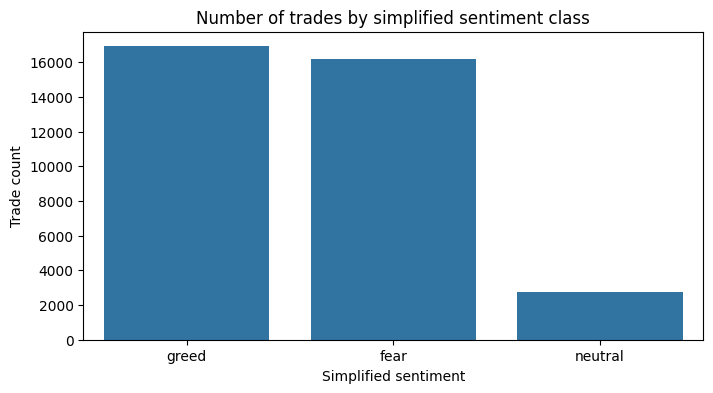

In [10]:

plt.figure(figsize=(8,4))
sns.countplot(x="sg_class", data=merged, order=merged["sg_class"].value_counts().index)
plt.title("Number of trades by simplified sentiment class")
plt.xlabel("Simplified sentiment")
plt.ylabel("Trade count")
plt.show()


,mean,median,count
classification,,,
Extreme Greed,205.816345,0.96048,5621
Fear,128.287950,0.00000,13869
Greed,53.988003,0.00000,11292
Neutral,27.088803,0.00000,2756
Extreme Fear,1.891632,0.00000,2326


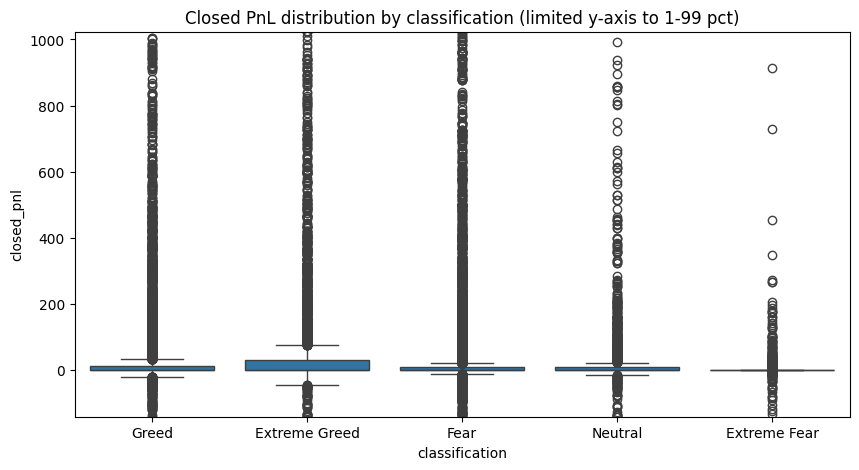

In [11]:
#Average closed PnL by original classification
if "classification" in merged.columns:
    agg = merged.groupby("classification")["closed_pnl"].agg(["mean","median","count"]).sort_values("mean", ascending=False)
    display(agg)
    plt.figure(figsize=(10,5))
    sns.boxplot(x="classification", y="closed_pnl", data=merged)
    plt.ylim(merged["closed_pnl"].quantile(0.01), merged["closed_pnl"].quantile(0.99))
    plt.title("Closed PnL distribution by classification (limited y-axis to 1-99 pct)")
    plt.show()
else:
    print("No 'classification' column present.")


sg_class
fear       36.90
greed      47.48
neutral    49.49
Name: win_rate, dtype: float64


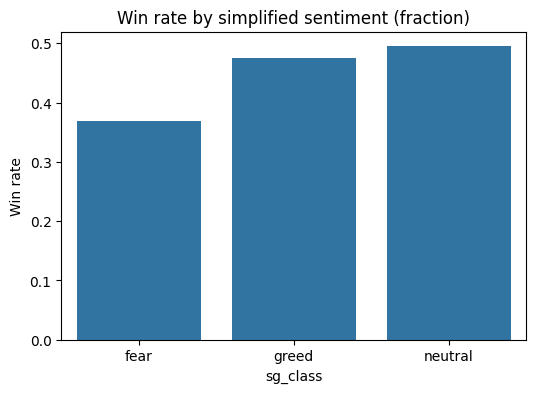

In [12]:
#Win rate by simplified sentiment
win_rate = merged.groupby("sg_class")["win"].mean().rename("win_rate")
print((win_rate * 100).round(2))
plt.figure(figsize=(6,4))
sns.barplot(x=win_rate.index, y=win_rate.values)
plt.title("Win rate by simplified sentiment (fraction)")
plt.ylabel("Win rate")
plt.show()


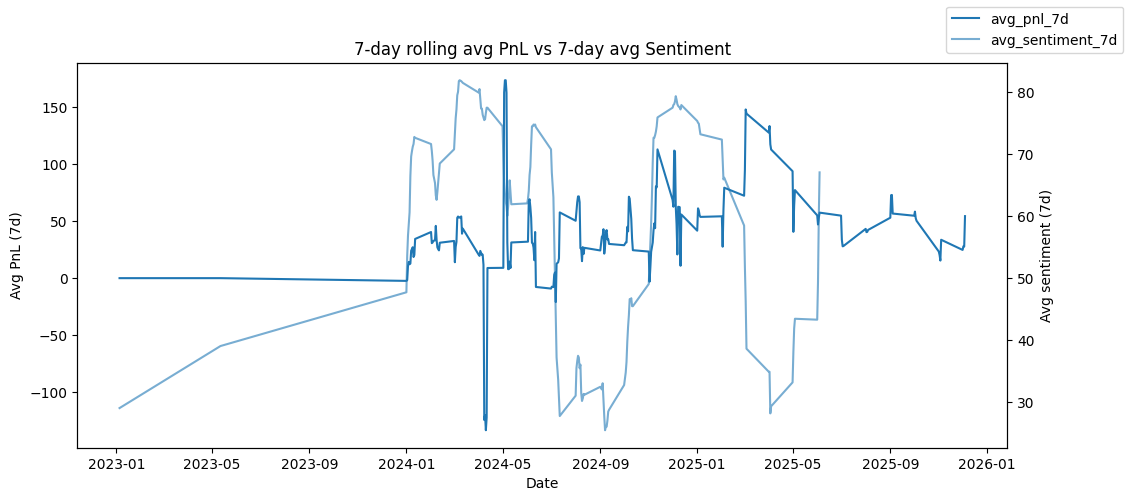

In [13]:
#Time series: daily avg_pnl and avg_sentiment over time
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(daily["date"], daily["avg_pnl_7d"], label="avg_pnl_7d")
ax1.set_ylabel("Avg PnL (7d)")
ax2 = ax1.twinx()
ax2.plot(daily["date"], daily["avg_sentiment_7d"], label="avg_sentiment_7d", alpha=0.6)
ax2.set_ylabel("Avg sentiment (7d)")
ax1.set_title("7-day rolling avg PnL vs 7-day avg Sentiment")
ax1.set_xlabel("Date")
fig.legend(loc="upper right")
plt.show()


In [14]:
#Correlation: daily avg sentiment vs avg pnl
mask = daily[["avg_pnl", "avg_sentiment"]].dropna()
pearson_r, pval_p = stats.pearsonr(mask["avg_sentiment"], mask["avg_pnl"])
spearman_r, pval_s = stats.spearmanr(mask["avg_sentiment"], mask["avg_pnl"])
print(f"Pearson r: {pearson_r:.4f} (p={pval_p:.3g}), Spearman r: {spearman_r:.4f} (p={pval_s:.3g})")


Pearson r: -0.0079 (p=0.921), Spearman r: 0.0494 (p=0.537)


In [15]:
# preparing two groups based on simplified sentiment
g_fear = merged.loc[merged["sg_class"] == "fear", "closed_pnl"].dropna()
g_greed = merged.loc[merged["sg_class"] == "greed", "closed_pnl"].dropna()

print("fear:", len(g_fear), "greed:", len(g_greed))

if len(g_fear) > 0 and len(g_greed) > 0:
    u_stat, p_val = stats.mannwhitneyu(g_fear, g_greed, alternative="two-sided")
    print("Mann-Whitney U:", u_stat, "p-value:", p_val)
else:
    print("Not enough samples in one of the groups for Mann-Whitney U.")

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

d = cohens_d(g_fear, g_greed) if len(g_fear)>1 and len(g_greed)>1 else np.nan
print("Cohen's d (fear vs greed):", d)


fear: 16195 greed: 16913
Mann-Whitney U: 122776380.0 p-value: 1.384301904177245e-68
Cohen's d (fear vs greed): 0.004005930555044778


In [16]:

model_df = merged.copy()

ts_col = ts_col

model_df = model_df.sort_values(ts_col)
cutoff_ts = model_df[ts_col].quantile(0.80)
train = model_df[model_df[ts_col] <= cutoff_ts].copy()
test = model_df[model_df[ts_col] > cutoff_ts].copy()
print("Train shape:", train.shape, "Test shape:", test.shape)

feature_cols = []
for f in ["log_size_usd", "pnl_last_50", "account_avg_pnl", "account_trade_count", "value", "pnl_per_usd"]:
    if f in model_df.columns:
        feature_cols.append(f)

if "is_buy" in model_df.columns:
    feature_cols.append("is_buy")
if "sg_class" in model_df.columns:
    feature_cols.append("sg_class")
if "coin" in model_df.columns:
    feature_cols.append("coin")
if "leverage" in model_df.columns:
    feature_cols.append("leverage")

print("Using features:", feature_cols)

X_train = train[feature_cols].copy()
y_train = train["win"].astype(int)
X_test = test[feature_cols].copy()
y_test = test["win"].astype(int)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
], remainder="drop")
RANDOM_STATE =42

clf = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(n_estimators=150,max_depth=5,min_samples_leaf=25, n_jobs=-1, random_state=RANDOM_STATE))
])

clf.fit(X_train, y_train)

def evaluate_clf(model, X, y, label="test"):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y, preds)
    print(f"=== {label} metrics ===")
    print("Accuracy:", acc)
    if probs is not None:
        print("ROC AUC:", roc_auc_score(y, probs))
    print(classification_report(y, preds, digits=4))
    cm = confusion_matrix(y, preds)
    print("Confusion matrix:\n", cm)

evaluate_clf(clf, X_train, y_train, label="train")
evaluate_clf(clf, X_test, y_test, label="test")


Train shape: (63417, 28) Test shape: (15808, 28)
Using features: ['log_size_usd', 'pnl_last_50', 'account_avg_pnl', 'account_trade_count', 'value', 'pnl_per_usd', 'is_buy', 'sg_class', 'coin']
=== train metrics ===
Accuracy: 0.9935190879417191
ROC AUC: 0.9999989799413123
              precision    recall  f1-score   support

           0     0.9888    1.0000    0.9944     36202
           1     1.0000    0.9849    0.9924     27215

    accuracy                         0.9935     63417
   macro avg     0.9944    0.9924    0.9934     63417
weighted avg     0.9936    0.9935    0.9935     63417

Confusion matrix:
 [[36202     0]
 [  411 26804]]
=== test metrics ===
Accuracy: 0.9900683198380567
ROC AUC: 0.9999962663806481
              precision    recall  f1-score   support

           0     0.9838    1.0000    0.9919      9561
           1     1.0000    0.9749    0.9873      6247

    accuracy                         0.9901     15808
   macro avg     0.9919    0.9874    0.9896     15808
w

In [17]:
pre = clf.named_steps["pre"]
num_out = num_cols
if cat_cols:

    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    ohe_cols = list(ohe.get_feature_names_out(cat_cols))
else:
    ohe_cols = []
feature_names = num_out + ohe_cols

importances = clf.named_steps["model"].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top features:")
display(fi.head(20))


Top features:


,0
pnl_per_usd,0.417277
pnl_last_50,0.182050
is_buy,0.118923
account_trade_count,0.055986
value,0.044332
account_avg_pnl,0.038144
coin_BTC,0.013397
sg_class_fear,0.011426
coin_HYPE,0.010644
sg_class_greed,0.009682


In [18]:


OUT_DIR = "/content/data/processed_output"
os.makedirs(OUT_DIR, exist_ok=True)

merged_path = os.path.join(OUT_DIR, "merged_trades_sentiment.csv")
daily_path = os.path.join(OUT_DIR, "daily_aggregates.csv")
model_path = os.path.join(OUT_DIR, "rf_win_model.joblib")

merged.to_csv(merged_path, index=False)
daily.to_csv(daily_path, index=False)
joblib.dump(clf, model_path)

print("Saved merged data ->", merged_path)
print("Saved daily aggregates ->", daily_path)
print("Saved model ->", model_path)


Saved merged data -> /content/data/processed_output/merged_trades_sentiment.csv
Saved daily aggregates -> /content/data/processed_output/daily_aggregates.csv
Saved model -> /content/data/processed_output/rf_win_model.joblib
